# Follow the Money: Predicting Startup Outcome Using Funding Data and Other Factors
### Group 20: Daniel White, Yiyao (Tato) Lu
### May 14, 2020

### Table of Contents

**I. Introduction**
<br>**II. Data**
<br>&nbsp;&nbsp;&nbsp;A. Distribution of Startup Characteristics
<br>&nbsp;&nbsp;&nbsp;B. Startup Funding
<br>**III. Regression Analysis**
<br> **IV. Machine Learning Analysis**
<br>  **V. Cluster Analysis**
<br> **VI. Conclusion**

## I. Introduction
It's well-known that it's difficult for startups and small businesses to survive. [In 2018, there were 30.2 million small businesses operating in the U.S.](https://www.sba.gov/sites/default/files/Whats-New-With-Small-Business-2018.pdf) It's estimated that only [2 in 5 of those businesses are profitable, while the others breakeven or even lose money.](https://smallbiztrends.com/2019/03/startup-statistics-small-business.html) Experts and investors look to a variety of factors to try and predict the outcome of a startup, ranging from [the founder's gender](https://hbr.org/2016/05/4-factors-that-predict-startup-success-and-one-that-doesnt) to [the influence of venture capitalists](https://dspace.mit.edu/bitstream/handle/1721.1/113149/1018306746-MIT.pdf?sequence=1&isAllowed=y). 

In this project, we look at about 50,000 companies listed on Crunchbase to examine the effect of funding on startup outcome and try to predict the probability that a startup is acquired (or still operating).

## II. Data

For our analyses, we use data about startup companies and investments via Crunchbase, published by user Andy_M on Kaggle (https://www.kaggle.com/arindam235/startup-investments-crunchbase). The dataset was last updated as of February 2020.

In [1]:
#Import the data and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_name = 'investments_VC.csv'
df = pd.read_csv(file_name, encoding = 'latin1')
df.isna().sum() 

permalink                4856
name                     4857
homepage_url             8305
category_list            8817
 market                  8824
 funding_total_usd       4856
status                   6170
country_code            10129
state_code              24133
region                  10129
city                    10972
funding_rounds           4856
founded_at              15740
founded_month           15812
founded_quarter         15812
founded_year            15812
first_funding_at         4856
last_funding_at          4856
seed                     4856
venture                  4856
equity_crowdfunding      4856
undisclosed              4856
convertible_note         4856
debt_financing           4856
angel                    4856
grant                    4856
private_equity           4856
post_ipo_equity          4856
post_ipo_debt            4856
secondary_market         4856
product_crowdfunding     4856
round_A                  4856
round_B                  4856
round_C   

Looking at missing data, we see thousands of rows where all values are NA. These are blank rows in the underlying file that were mistakenly read in. To drop these rows, we use the dropna function.

In [2]:
df = df.dropna(how = 'all')
df.isna().sum()

permalink                   0
name                        1
homepage_url             3449
category_list            3961
 market                  3968
 funding_total_usd          0
status                   1314
country_code             5273
state_code              19277
region                   5273
city                     6116
funding_rounds              0
founded_at              10884
founded_month           10956
founded_quarter         10956
founded_year            10956
first_funding_at            0
last_funding_at             0
seed                        0
venture                     0
equity_crowdfunding         0
undisclosed                 0
convertible_note            0
debt_financing              0
angel                       0
grant                       0
private_equity              0
post_ipo_equity             0
post_ipo_debt               0
secondary_market            0
product_crowdfunding        0
round_A                     0
round_B                     0
round_C   

In [3]:
#Clean data

#remove white spaces in column names
df.rename(columns={' market ': 'market', ' funding_total_usd ': 'funding_total_usd'}, inplace=True)

# want to fill in NaNs on status so we know how many unknowns are present
df['status'].fillna('unknown', inplace = True)

# note: the source data placed commas in the wrong position
# but if we strip out commas and white space, the numbers are still accurate 
# e.g. the funding for Waywire is supposed to be $1,750,000, but shows up in the data as "17,50,000"
df['funding_total_usd'].replace('[- ,]', '', regex = True, inplace = True)
df['funding_total_usd'] = pd.to_numeric(df['funding_total_usd'])

df.head()

,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,...,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,1750000.0,acquired,USA,NY,New York City,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/organization/tv-communications,&TV Communications,http://enjoyandtv.com,|Games|,Games,4000000.0,operating,USA,CA,Los Angeles,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,40000.0,operating,EST,NaN,Tallinn,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,1500000.0,operating,GBR,NaN,London,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,/organization/r-ranch-and-mine,-R- Ranch and Mine,NaN,|Tourism|Entertainment|Games|,Tourism,60000.0,operating,USA,TX,Dallas,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The dataset contains 49,438 observations with 39 variables, which include nominal variables (name of the startup, homepage URL, category, etc.), numerical variables (total funding, funding by source such as seed, VC, etc.), and date variables (founding date, first funding date, etc).

In [4]:
df.shape

(49438, 39)

To explore the data, we chart the distribution of startups by status and other variables.

### A. Distribution of Startup Characteristics

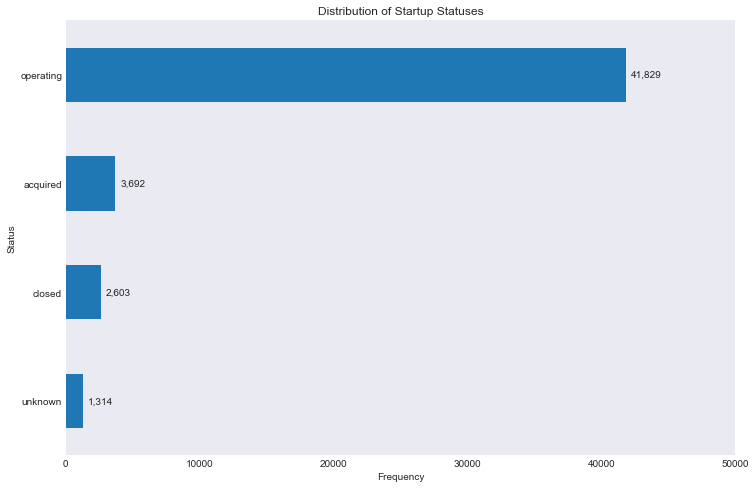

In [5]:
plt.style.use('seaborn-dark')

def horizontal_distribution(chart_data, title = '', xlab = '', ylab = '', xlim = 50000):
    plt.figure(figsize=(12, 8))
    ax = chart_data.sort_values().plot(kind='barh')
    ax.set_title(title)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_xlim([0, xlim])
    rects = ax.patches

    # For each bar: Place a label
    for rect in rects:
        # Get X and Y placement of label from rect.
        x_value = rect.get_width()
        y_value = rect.get_y() + rect.get_height() / 2

        # Number of points between bar and label. Change to your liking.
        space = 5
        # Vertical alignment for positive values
        ha = 'left'

        # Use X value as label and format number with one decimal place
        label = "{:,}".format(x_value)

        # Create annotation
        plt.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(space, 0),          # Horizontally shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            va='center',                # Vertically center label
            ha=ha)                      # Horizontally align label differently for
                                        # positive and negative values.

horizontal_distribution(df['status'].value_counts(), 'Distribution of Startup Statuses', 'Frequency', 'Status', 50000)

Most of the startups in the data are still operating. Over 84% are operating, while only about 7% have been acquired.

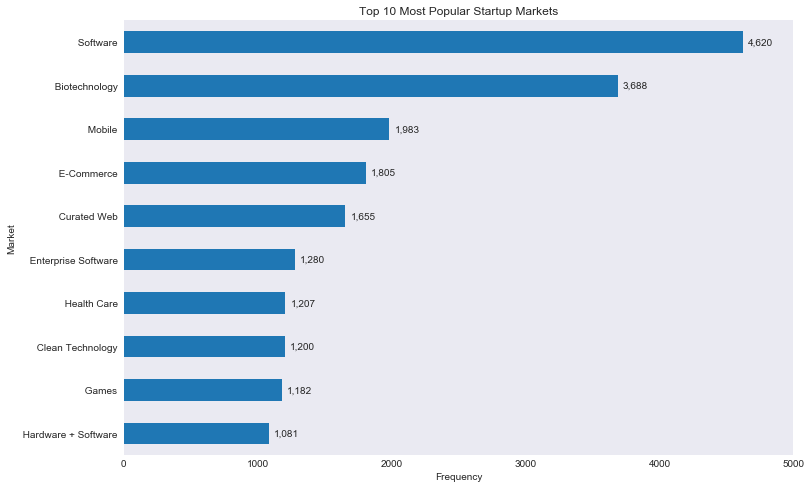

In [6]:
mkt_freq = df['market'].value_counts()
horizontal_distribution(mkt_freq.head(10), 'Top 10 Most Popular Startup Markets', 'Frequency', 'Market', 5000)

Most startups are in the tech industry, ranging from games to biotech. The most popular market is software, with more than 4,600 startups.

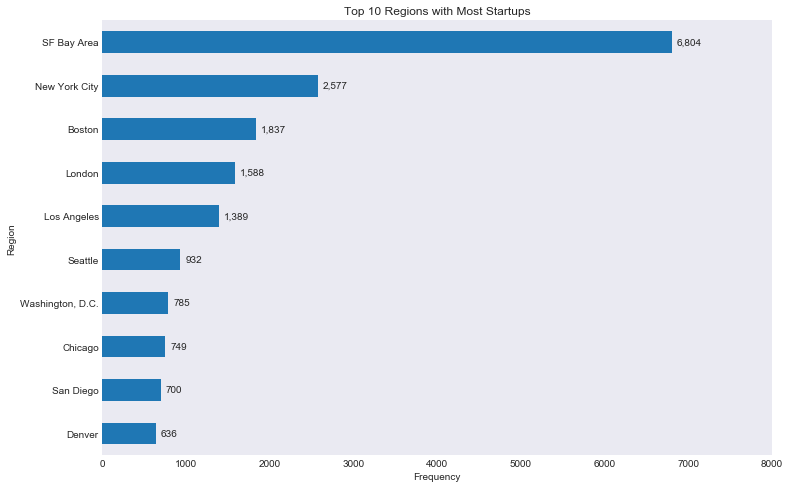

In [7]:
region_freq = df['region'].value_counts()
horizontal_distribution(region_freq.head(10), 'Top 10 Regions with Most Startups', 'Frequency', 'Region', 8000)

The biggest hotspot for startups is the SF Bay Area, with more than twice as many startups as New York City. Many of the most popular regions for startups are in the US, except for London.

### B. Startup Funding

Funding is an important factor when considering startup performance. Before a business can operate, it needs capital and resources. With that in mind, we think that funding could be a reasonable predictor for a startup's outcome. To explore this idea, we take a closer look at funding and the sources of funding for startups in the data.

Text(0, 0.5, 'Frequency')

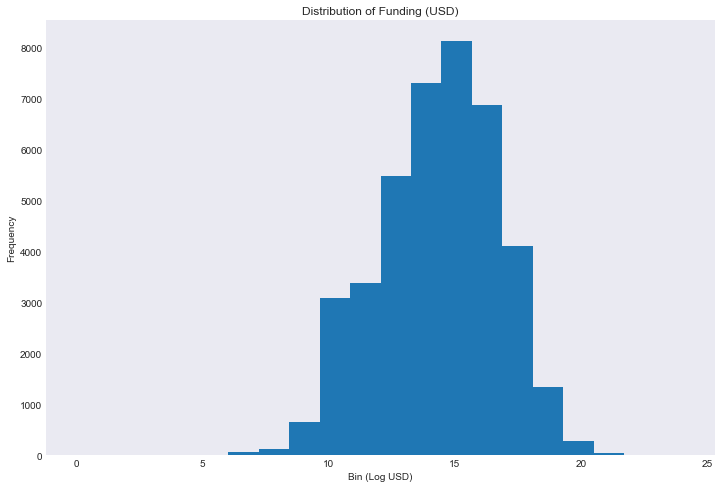

In [8]:
log_funding = np.log(df['funding_total_usd'].dropna())

plt.figure(figsize=(12, 8))
ax = log_funding.plot(kind='hist', bins = 20)
ax.set_title('Distribution of Funding (USD)')
ax.set_xlabel('Bin (Log USD)')
ax.set_ylabel('Frequency')

The distribution of total funding looks like a log-normal distribution with a longer left-tail, giving it a slight skew to the left. This means that there are more startups with extremely low funding than those with extremely high funding.

Text(0, 0.5, 'Density')

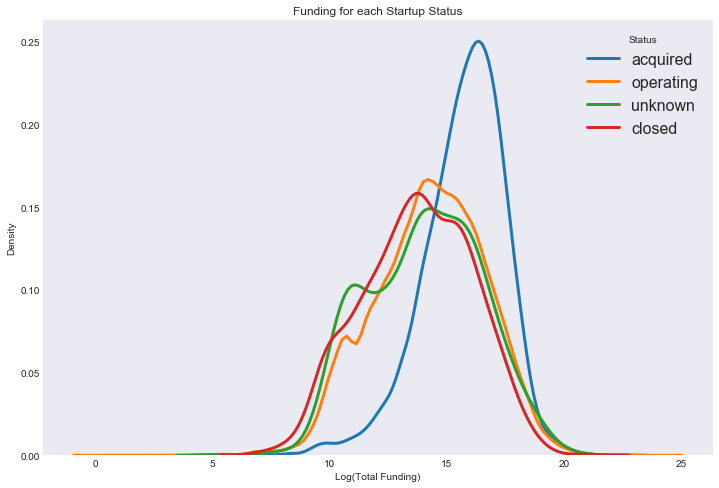

In [9]:
plt.figure(figsize=(12, 8))

# Iterate through the five airlines
for k in df['status'].unique():
    # Subset to the airline
    subset = df[df['status'] == k]
    
    # Draw the density plot
    sns.distplot(np.log(subset['funding_total_usd'].dropna()), hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = k)

plt.legend(prop={'size': 16}, title = 'Status')
plt.title('Funding for each Startup Status')
plt.xlabel('Log(Total Funding)')
plt.ylabel('Density')

If we compare funding distributions for each startup status, we see that **acquired startups tend to have higher total funding.** 

In [10]:
top10_funding = df['funding_total_usd'].sort_values(ascending = False).head(10)
df_filter = df.loc[df['funding_total_usd'].isin(top10_funding),['name', 'market', 'funding_total_usd', 'status', 'founded_at']]
df_filter.rename(columns = {'funding_total_usd': 'funding_total_usd_billions'}, inplace = True)
df_filter['funding_total_usd_billions'] = df_filter['funding_total_usd_billions']/1000000000
df_filter.sort_values(by = 'funding_total_usd_billions', ascending = False)

,name,market,funding_total_usd_billions,status,founded_at
45815,Verizon Communications,Mobile,30.079503,operating,1983-10-07
36911,Sberbank,Finance,5.800000,operating,NaN
8664,Clearwire,Internet,5.700000,acquired,2003-10-01
7977,Charter Communications,NaN,5.162513,operating,1993-01-01
15315,First Data Corporation,Trading,3.500000,operating,1971-01-01
9155,COFCO,NaN,3.200000,operating,NaN
38289,sigmacare,Health and Wellness,2.600000,operating,2005-01-01
14705,Facebook,Communities,2.425700,operating,2004-02-04
7328,Carestream,Biotechnology,2.400000,operating,2007-01-01
15569,Flipkart,Online Shopping,2.351140,operating,2007-09-01


The biggest startups in the data are often large, established companies such as Verizon or Facebook. Most of these companies are operating, with the exception of Clearwire which was acquired by Sprint. 

In [11]:
acquired = df.loc[df['status'].isin({'acquired'}),:]
top10_funding = acquired['funding_total_usd'].sort_values(ascending = False).head(10)
df_filter = acquired.loc[acquired['funding_total_usd'].isin(top10_funding),['name', 'market', 'funding_total_usd', 'status', 'founded_at']]
df_filter.rename(columns = {'funding_total_usd': 'funding_total_usd_billions'}, inplace = True)
df_filter['funding_total_usd_billions'] = df_filter['funding_total_usd_billions']/1000000000
df_filter.sort_values(by = 'funding_total_usd_billions', ascending = False)

,name,market,funding_total_usd_billions,status,founded_at
8664,Clearwire,Internet,5.700000,acquired,2003-10-01
15360,Fisker Automotive,Automotive,1.451000,acquired,2008-01-01
42470,Terra-Gen Power,Clean Technology,1.200000,acquired,NaN
4910,Better Place,Clean Technology,0.925000,acquired,2007-10-29
33231,PPTV,Photography,0.706500,acquired,2004-01-01
36522,Sabre,Software,0.645496,acquired,1960-01-01
41135,SunEdison,Clean Technology,0.640800,acquired,2003-01-01
16419,G4S,Security,0.541000,acquired,NaN
15330,First Wind,Renewable Energies,0.522000,acquired,NaN
4606,Beats Electronics,Hardware,0.500000,acquired,2006-01-01


Filtering on acquired startups only, we see that total funding is much lower than the overall top 10 in the data. This would suggest that, in terms of funding, the highest highs are greater among operating companies than acquired companies. At the same time, the density plot showed a larger chunk of acquired startups have more funding than operating startups, i.e. the distribution of funding among operating startups is more left-skewed than acquired startups. 

The main takeaway is that **we expect funding to increase the probability of acquisition** for the average startup. For a few exceptional cases such as Facebook, we expect the startup to continue operating and to accumulate further funding. 

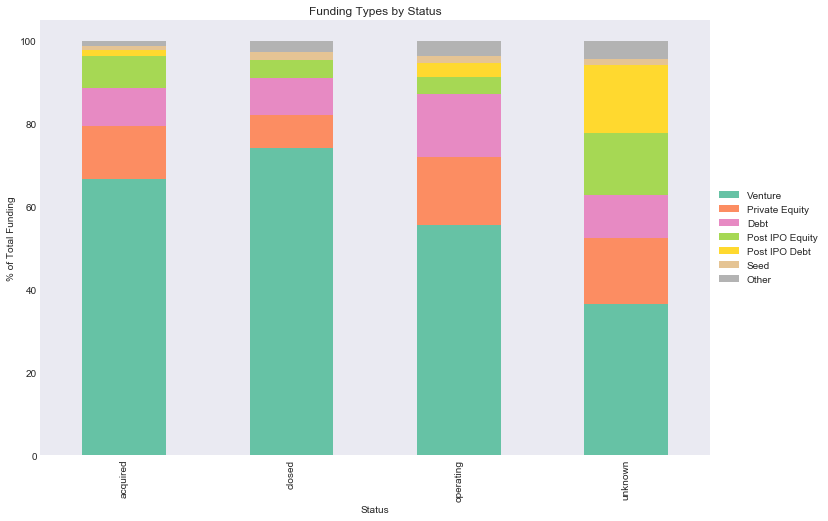

In [12]:
cols = ['seed'
       , 'venture'
       , 'equity_crowdfunding'
       , 'undisclosed'
       , 'convertible_note'
       , 'debt_financing'
       , 'angel'
       , 'grant'
       , 'private_equity'
       , 'post_ipo_equity'
       , 'post_ipo_debt'
       , 'secondary_market'
       , 'product_crowdfunding']
funding_aggregate = df.groupby(['status'])[cols].agg('sum')

funding_aggregate[cols] = funding_aggregate[cols].div(funding_aggregate[cols].sum(axis=1), axis=0).multiply(100)
funding_aggregate



chart_data = pd.DataFrame({'Status': funding_aggregate.index
                           , 'Seed': funding_aggregate['seed']
                           , 'Venture': funding_aggregate['venture']
                           , 'Debt': funding_aggregate['debt_financing']
                           , 'Private Equity': funding_aggregate['private_equity']
                           , 'Post IPO Equity': funding_aggregate['post_ipo_equity']
                           , 'Post IPO Debt': funding_aggregate['post_ipo_debt']
                           , 'Other': funding_aggregate[{'equity_crowdfunding'
                                                         , 'undisclosed'
                                                         , 'convertible_note'
                                                         , 'angel'
                                                         , 'grant'
                                                         , 'secondary_market'
                                                         , 'product_crowdfunding'}].sum(axis = 1)
                          })

chart_data

palette = sns.color_palette("Set2")

plt.figure(figsize=(12, 8))
chart_data['Venture'].plot.bar(stacked = True, color = palette[0])
chart_data['Private Equity'].plot.bar(stacked = True, bottom = chart_data['Venture'], color = palette[1])
chart_data['Debt'].plot.bar(stacked = True, bottom = chart_data['Venture'] 
                            + chart_data['Private Equity'], color = palette[3])
chart_data['Post IPO Equity'].plot.bar(stacked = True, bottom = chart_data['Venture'] 
                            + chart_data['Private Equity']
                            + chart_data['Debt']
                            , color =  palette[4])
chart_data['Post IPO Debt'].plot.bar(stacked = True, bottom = chart_data['Venture'] 
                            + chart_data['Private Equity']
                            + chart_data['Debt']
                            + chart_data['Post IPO Equity']
                            , color =  palette[5])
chart_data['Seed'].plot.bar(stacked = True, bottom = chart_data['Venture'] 
                            + chart_data['Private Equity']
                            + chart_data['Debt']
                            + chart_data['Post IPO Equity']
                            + chart_data['Post IPO Debt']
                            , color =  palette[6])
chart_data['Other'].plot.bar(stacked = True, bottom = chart_data['Venture'] 
                            + chart_data['Private Equity']
                            + chart_data['Debt']
                            + chart_data['Post IPO Equity']
                            + chart_data['Post IPO Debt']
                            + chart_data['Seed']
                            , color =  palette[7])
plt.legend(prop={'size': 16}, title = 'Status')
plt.title('Funding Types by Status')
plt.xlabel('Status')
plt.ylabel('% of Total Funding')
plt.legend(loc = 'center left', bbox_to_anchor = (1 , 0.5))

In [13]:
chart_data

,Status,Seed,Venture,Debt,Private Equity,Post IPO Equity,Post IPO Debt,Other
status,,,,,,,,
acquired,acquired,0.859360,66.753493,9.178759,12.709003,7.764364,1.490663,1.244359
closed,closed,2.014796,74.214853,8.917659,7.939449,4.319861,0.000000,2.593381
operating,operating,1.756648,55.543811,15.359625,16.439757,3.918840,3.404080,3.577240
unknown,unknown,1.403465,36.436375,10.300145,16.084876,14.964753,16.421018,4.389368


If we take total funding for each type of startup by status, we can see how acquired startups differ from other startups in terms of funding. The chart shows that, compared to operating startups, acquired startups derive more of their funding from venture capital and post-IPO equity. In contrast, operating companies get more funding from debt, private equity, seed capital, and other sources of funding. These sources of funding may explain the differences in distribution among acquired startups and operating startups.

So far, the data suggests that in addition to total funding, **venture capital and post-IPO equity may be positive predictors of whether a startup gets acquired.** To test our hypothesis and quantify the predictive power of funding, we utilize regression and machine learning techniques.

## III. Regression Analysis

In order to run a regression predicting startup status, we must first turn our categorical data into numbers. Using the method below we will create a new dataframe called df_regress which will turn our status from closed, operating, acquired, and unknown, into 0, 1, 2, and 3 respectively 


In [669]:
df_regress = df.copy()
df_regress['status'] = df_regress['status'].astype('category')
df_regress['status'] = df_regress['status'].cat.reorder_categories(['closed', 'operating', 'acquired','unknown'], ordered=True)
df_regress['status'] = df_regress['status'].cat.codes
print(df_regress['status'])

0        2
1        1
2        1
3        1
4        1
        ..
49433    1
49434    1
49435    1
49436    1
49437    1
Name: status, Length: 49438, dtype: int8


An issue we have to deal with for our predictive analyses is the startups listed with an unknown status. Since these actually belong to 1 of the other 3 categories, it will be best to not use them for our regression and machine learning models as they could skew the results.

In [670]:
df_regress = df_regress.drop(df_regress[df_regress['status']==3].index)
print(df_regress['status'])

0        2
1        1
2        1
3        1
4        1
        ..
49433    1
49434    1
49435    1
49436    1
49437    1
Name: status, Length: 48124, dtype: int8


Since we are most interested in predicting whether a startup gets acquired, we will create a new column labeled "acquired" in our dataframe that gives us a binary answer of 1 if the startup has been acquired or 0 if the startup has not been acquired. 

In [671]:
df_regress['acquired']=df_regress['status'] #creating new column
df_regress['acquired']=df_regress['acquired'].replace([0,1,2],[0,0,1]) #changing values to either 0 or 1 for acquired status
print(df_regress['acquired'])

0        1
1        0
2        0
3        0
4        0
        ..
49433    0
49434    0
49435    0
49436    0
49437    0
Name: acquired, Length: 48124, dtype: int64


Now we are ready to start running some analyses

In [672]:
import statsmodels.formula.api as smf

Regression including all Funding

In [673]:
smf.ols('acquired ~ seed + venture + equity_crowdfunding + undisclosed + convertible_note + debt_financing + angel + grant + private_equity + post_ipo_equity + post_ipo_debt + secondary_market + product_crowdfunding',data=df_regress).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               acquired   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     15.99
Date:                Thu, 14 May 2020   Prob (F-statistic):           3.96e-37
Time:                        18:39:11   Log-Likelihood:                -4478.7
No. Observations:               48124   AIC:                             8985.
Df Residuals:                   48110   BIC:                             9108.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0729      0.001     56.628      0.000       0.070       0.075
seed                 -2.461e-09   1.16e-09     -2.126      0.034   -4.73e-09   -1.92e-10
venture               5.813e-10   4.23e-11     13.756      0.000    4.98e-10    6.64e-10
equity_crowdfunding  -6.627e-09   5.98e-09     -1.108      0.268   -1.84e-08     5.1e-09
undisclosed           1.869e-10   4.08e-10      0.459      0.647   -6.12e-10    9.86e-10
convertible_note     -6.374e-10   8.35e-10     -0.764      0.445   -2.27e-09    9.98e-10
debt_financing       -1.116e-12   8.65e-12     -0.129      0.897   -1.81e-11    1.58e-11
angel                 2.034e-11   1.82e-09      0.011      0.991   -3.55e-09    3.59e-09
grant                -3.536e-10   2.14e-10     -1.654      0.098   -7.73e-10    6.54e-11
private_equity        6.838e-12   3.79e-11      0.180      0.857   -6.75e-11    8.12e-11
post_ipo_equity       1.088e-10    4.6e-11      2.368      0.018    1.88e-11    1.99e-10
post_ipo_debt        -2.488e-11   3.62e-11     -0.688      0.492   -9.58e-11     4.6e-11
secondary_market      -4.74e-10    3.1e-10     -1.530      0.126   -1.08e-09    1.33e-10
product_crowdfunding -1.234e-09   2.85e-09     -0.433      0.665   -6.82e-09    4.36e-09
==============================================================================
Omnibus:                    30086.996   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           210504.901
Skew:                           3.154   Prob(JB):                         0.00
Kurtosis:                      11.073   Cond. No.                     1.49e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

All Funding + State

In [360]:
smf.ols('acquired ~ state_code + seed + venture + equity_crowdfunding + undisclosed + convertible_note + debt_financing + angel + grant + private_equity + post_ipo_equity + post_ipo_debt + secondary_market + product_crowdfunding',data=df_regress).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               acquired   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     8.464
Date:                Thu, 14 May 2020   Prob (F-statistic):           3.77e-86
Time:                        13:09:55   Log-Likelihood:                -5744.1
No. Observations:               29550   AIC:                         1.164e+04
Df Residuals:                   29476   BIC:                         1.225e+04
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0171      0.028      0.600      0.549      -0.039       0.073
state_code[T.AK]        -0.0154      0.090     -0.172      0.863      -0.191       0.160
state_code[T.AL]         0.0105      0.040      0.259      0.796      -0.069       0.090
state_code[T.AR]        -0.0171      0.036     -0.473      0.636      -0.088       0.054
state_code[T.AZ]         0.0259      0.033      0.788      0.431      -0.039       0.090
state_code[T.BC]         0.0433      0.033      1.311      0.190      -0.021       0.108
state_code[T.CA]         0.1176      0.029      4.109      0.000       0.062       0.174
state_code[T.CO]         0.0679      0.031      2.226      0.026       0.008       0.128
state_code[T.CT]         0.0418      0.033      1.264      0.206      -0.023       0.107
state_code[T.DC]         0.0308      0.036      0.858      0.391      -0.040       0.101
state_code[T.DE]         0.0113      0.045      0.249      0.804      -0.078       0.100
state_code[T.FL]         0.0230      0.030      0.766      0.443      -0.036       0.082
state_code[T.GA]         0.0526      0.031      1.687      0.092      -0.009       0.114
state_code[T.HI]        -0.0164      0.049     -0.332      0.740      -0.113       0.080
state_code[T.IA]         0.0326      0.044      0.739      0.460      -0.054       0.119
state_code[T.ID]         0.0001      0.049      0.003      0.998      -0.096       0.096
state_code[T.IL]         0.0651      0.030      2.150      0.032       0.006       0.124
state_code[T.IN]         0.0076      0.034      0.221      0.825      -0.060       0.075
state_code[T.KS]         0.0032      0.042      0.076      0.939      -0.078       0.085
state_code[T.KY]         0.0086      0.040      0.218      0.828      -0.069       0.086
state_code[T.LA]        -0.0045      0.044     -0.102      0.919      -0.090       0.081
state_code[T.MA]         0.1054      0.029      3.606      0.000       0.048       0.163
state_code[T.MB]         0.0575      0.086      0.665      0.506      -0.112       0.227
state_code[T.MD]         0.0687      0.031      2.185      0.029       0.007       0.130
state_code[T.ME]         0.0425      0.051      0.838      0.402      -0.057       0.142
state_code[T.MI]         0.0112      0.033      0.340      0.734      -0.054       0.076
state_code[T.MN]         0.0495      0.033      1.522      0.128      -0.014       0.113
state_code[T.MO]         0.0282      0.035      0.812      0.417      -0.040       0.096
state_code[T.MS]         0.0468      0.060      0.780      0.435      -0.071       0.164
state_code[T.MT]         0.0503      0.062      0.817      0.414      -0.070       0.171
state_code[T.NB]        -0.0156      0.108     -0.145      0.885      -0.227       0.196
state_code[T.NC]         0.0380      0.032      1.205    

All Funding + Country

In [361]:
smf.ols('acquired ~ country_code + seed + venture + equity_crowdfunding + undisclosed + convertible_note + debt_financing + angel + grant + private_equity + post_ipo_equity + post_ipo_debt + secondary_market + product_crowdfunding',data=df_regress).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               acquired   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     5.134
Date:                Thu, 14 May 2020   Prob (F-statistic):           7.69e-71
Time:                        13:10:06   Log-Likelihood:                -4756.4
No. Observations:               43057   AIC:                             9769.
Df Residuals:                   42929   BIC:                         1.088e+04
Df Model:                         127                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -4.579e-07      0.271  -1.69e-06      1.000      -0.530       0.530
country_code[T.ARE]      0.0594      0.273      0.218      0.828      -0.475       0.594
country_code[T.ARG]      0.0282      0.272      0.104      0.917      -0.504       0.561
country_code[T.ARM]     -0.0063      0.331     -0.019      0.985      -0.656       0.643
country_code[T.AUS]      0.0397      0.271      0.146      0.884      -0.492       0.571
country_code[T.AUT]      0.0479      0.272      0.176      0.860      -0.485       0.581
country_code[T.AZE]      0.0004      0.313      0.001      0.999      -0.612       0.613
country_code[T.BEL]      0.0597      0.272      0.220      0.826      -0.473       0.592
country_code[T.BGD]     -0.0023      0.289     -0.008      0.994      -0.569       0.565
country_code[T.BGR]      0.0441      0.273      0.162      0.871      -0.490       0.578
country_code[T.BHR]   8.193e-05      0.313      0.000      1.000      -0.612       0.613
country_code[T.BHS]     -0.0002      0.331     -0.001      1.000      -0.650       0.649
country_code[T.BLR]   5.309e-05      0.331      0.000      1.000      -0.650       0.650
country_code[T.BMU]      0.2400      0.303      0.793      0.428      -0.353       0.833
country_code[T.BRA]      0.0180      0.271      0.066      0.947      -0.514       0.549
country_code[T.BRN]  -1.226e-06      0.383   -3.2e-06      1.000      -0.750       0.750
country_code[T.BWA]     -0.0003      0.303     -0.001      0.999      -0.593       0.593
country_code[T.CAN]      0.0743      0.271      0.274      0.784      -0.456       0.605
country_code[T.CHE]      0.0465      0.271      0.171      0.864      -0.485       0.578
country_code[T.CHL]      0.0145      0.271      0.053      0.957      -0.517       0.546
country_code[T.CHN]      0.0106      0.271      0.039      0.969      -0.520       0.541
country_code[T.CIV]      0.0002      0.383      0.001      1.000      -0.750       0.750
country_code[T.CMR]  -3.035e-05      0.331  -9.16e-05      1.000      -0.650       0.650
country_code[T.COL]      0.0299      0.275      0.109      0.913      -0.508       0.568
country_code[T.CRI]      0.0003      0.292      0.001      0.999      -0.573       0.573
country_code[T.CYM]     -0.0041      0.283     -0.014      0.988      -0.558       0.550
country_code[T.CYP]     -0.0018      0.282     -0.006      0.995      -0.554       0.550
country_code[T.CZE]      0.0410      0.273      0.150      0.881      -0.495       0.577
country_code[T.DEU]      0.0754      0.271      0.278      0.781      -0.455       0.606
country_code[T.DNK]      0.0610      0.271      0.225      0.822      -0.471       0.593
country_code[T.DOM]      0.0023      0.313      0.007      0.994      -0.610       0.615
country_code[T.DZA]      0.0002      0.278      0.001    

All Funding + Market

In [362]:
smf.ols('acquired ~ market + seed + venture + equity_crowdfunding + undisclosed + convertible_note + debt_financing + angel + grant + private_equity + post_ipo_equity + post_ipo_debt + secondary_market + product_crowdfunding',data=df_regress).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               acquired   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     2.066
Date:                Thu, 14 May 2020   Prob (F-statistic):           2.61e-57
Time:                        13:10:30   Log-Likelihood:                -4168.9
No. Observations:               44535   AIC:                             9868.
Df Residuals:                   43770   BIC:                         1.653e+04
Df Model:                         764                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             0.0399      0.054      0.744      0.457      -0.065       0.145
market[T. 3D Printing ]                              -0.0402      0.104     -0.386      0.699      -0.244       0.164
market[T. 3D Technology ]                            -0.0368      0.109     -0.338      0.735      -0.250       0.177
market[T. Accounting ]                                0.0677      0.083      0.817      0.414      -0.095       0.230
market[T. Ad Targeting ]                              0.0353      0.092      0.385      0.701      -0.144       0.215
market[T. Advanced Materials ]                       -0.0399      0.197     -0.202      0.840      -0.426       0.346
market[T. Adventure Travel ]                         -0.0398      0.122     -0.326      0.744      -0.279       0.199
market[T. Advertising ]                               0.0819      0.054      1.510      0.131      -0.024       0.188
market[T. Advertising Exchanges ]                    -0.0611      0.197     -0.310      0.756      -0.447       0.325
market[T. Advertising Networks ]                     -0.0404      0.144     -0.280      0.779      -0.323       0.242
market[T. Advertising Platforms ]                    -0.0072      0.074     -0.098      0.922      -0.152       0.137
market[T. Advice ]                                    0.0350      0.092      0.382      0.702      -0.145       0.215
market[T. Aerospace ]                                 0.0048      0.080      0.060      0.952      -0.153       0.162
market[T. Agriculture ]                               0.0657      0.074      0.884      0.377      -0.080       0.212
market[T. Algorithms ]                               -0.0391      0.131     -0.298      0.766      -0.297       0.218
market[T. All Markets ]                               0.0994      0.115      0.867      0.386      -0.125       0.324
market[T. All Students ]                             -0.0410      0.084     -0.487      0.626      -0.206       0.124
market[T. Alternative Medicine ]                     -0.0418      0.197     -0.212      0.832      -0.428       0.344
market[T. Alumni ]                                   -0.0399      0.273     -0.146      0.884      -0.576       0.496
market[T. Analytics ]                                 0.0455      0.055      0.832      0.405      -0.062       0.153
market[T. Android ]                                   0.0722      0.061      1.190      0.234      -0.047       0.191
market[T. Angels ]                                   -0.0378      0.197     -0.192      0.848      -0.424       0.348
market[T. Animal Feed ]                              -0.0389      0.197     -0.197      0.844      -0.425       0.347
market[T. App D

All Funding + State + Year Founded

In [363]:
smf.ols('acquired ~ founded_year + state_code + seed + venture + equity_crowdfunding + undisclosed + convertible_note + debt_financing + angel + grant + private_equity + post_ipo_equity + post_ipo_debt + secondary_market + product_crowdfunding',data=df_regress).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               acquired   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     13.38
Date:                Thu, 14 May 2020   Prob (F-statistic):          1.35e-156
Time:                        13:10:39   Log-Likelihood:                -4537.6
No. Observations:               24231   AIC:                             9225.
Df Residuals:                   24156   BIC:                             9832.
Df Model:                          74                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               10.2953      0.484     21.263      0.000       9.346      11.244
state_code[T.AK]        -0.0322      0.094     -0.342      0.732      -0.217       0.152
state_code[T.AL]        -0.0357      0.048     -0.750      0.453      -0.129       0.058
state_code[T.AR]        -0.0318      0.040     -0.792      0.428      -0.111       0.047
state_code[T.AZ]         0.0072      0.038      0.192      0.848      -0.067       0.081
state_code[T.BC]         0.0262      0.038      0.692      0.489      -0.048       0.100
state_code[T.CA]         0.1070      0.033      3.216      0.001       0.042       0.172
state_code[T.CO]         0.0496      0.035      1.406      0.160      -0.020       0.119
state_code[T.CT]         0.0175      0.038      0.459      0.647      -0.057       0.092
state_code[T.DC]         0.0353      0.041      0.869      0.385      -0.044       0.115
state_code[T.DE]        -0.0025      0.053     -0.048      0.962      -0.106       0.101
state_code[T.FL]         0.0045      0.035      0.129      0.897      -0.064       0.073
state_code[T.GA]         0.0361      0.036      1.007      0.314      -0.034       0.106
state_code[T.HI]        -0.0238      0.056     -0.425      0.671      -0.133       0.086
state_code[T.IA]         0.0135      0.049      0.276      0.783      -0.083       0.110
state_code[T.ID]        -0.0281      0.054     -0.520      0.603      -0.134       0.078
state_code[T.IL]         0.0467      0.035      1.337      0.181      -0.022       0.115
state_code[T.IN]        -0.0103      0.040     -0.260      0.795      -0.088       0.067
state_code[T.KS]        -0.0124      0.047     -0.263      0.792      -0.105       0.080
state_code[T.KY]        -0.0019      0.046     -0.041      0.967      -0.092       0.088
state_code[T.LA]        -0.0300      0.050     -0.601      0.548      -0.128       0.068
state_code[T.MA]         0.0874      0.034      2.575      0.010       0.021       0.154
state_code[T.MB]         0.0210      0.091      0.232      0.817      -0.157       0.199
state_code[T.MD]         0.0438      0.036      1.207      0.227      -0.027       0.115
state_code[T.ME]        -0.0279      0.060     -0.464      0.643      -0.146       0.090
state_code[T.MI]        -0.0192      0.038     -0.501      0.616      -0.094       0.056
state_code[T.MN]         0.0149      0.037      0.398      0.691      -0.058       0.088
state_code[T.MO]         0.0008      0.040      0.020      0.984      -0.077       0.078
state_code[T.MS]        -0.0052      0.068     -0.077      0.939      -0.139       0.129
state_code[T.MT]         0.0474      0.071      0.671      0.502      -0.091       0.186
state_code[T.NB]        -0.0233      0.124     -0.188      0.851      -0.266       0.219
state_code[T.NC]         0.0039      0.036      0.106    

All Funding + Country + Year Founded

In [364]:
smf.ols('acquired ~ founded_year + country_code + seed + venture + equity_crowdfunding + undisclosed + convertible_note + debt_financing + angel + grant + private_equity + post_ipo_equity + post_ipo_debt + secondary_market + product_crowdfunding',data=df_regress).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               acquired   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     8.558
Date:                Thu, 14 May 2020   Prob (F-statistic):          9.52e-145
Time:                        13:10:43   Log-Likelihood:                -3889.0
No. Observations:               34627   AIC:                             8026.
Df Residuals:                   34503   BIC:                             9074.
Df Model:                         123                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                9.3232      0.479     19.464      0.000       8.384      10.262
country_code[T.ARE]      0.0358      0.274      0.131      0.896      -0.501       0.572
country_code[T.ARG]      0.0044      0.272      0.016      0.987      -0.529       0.538
country_code[T.ARM]     -0.0298      0.332     -0.090      0.928      -0.681       0.621
country_code[T.AUS]      0.0120      0.272      0.044      0.965      -0.521       0.545
country_code[T.AUT]      0.0357      0.273      0.131      0.896      -0.499       0.571
country_code[T.AZE]     -0.0089      0.313     -0.029      0.977      -0.623       0.605
country_code[T.BEL]      0.0318      0.272      0.117      0.907      -0.502       0.566
country_code[T.BGD]     -0.0214      0.290     -0.074      0.941      -0.590       0.547
country_code[T.BGR]      0.0426      0.274      0.156      0.876      -0.494       0.579
country_code[T.BHR]     -0.0092      0.313     -0.029      0.977      -0.623       0.605
country_code[T.BHS]     -0.0184      0.332     -0.055      0.956      -0.669       0.633
country_code[T.BLR]     -0.0185      0.332     -0.056      0.956      -0.670       0.633
country_code[T.BMU]      0.2627      0.313      0.839      0.402      -0.351       0.877
country_code[T.BRA]      0.0017      0.272      0.006      0.995      -0.531       0.534
country_code[T.BRN]     -0.0046      0.384     -0.012      0.990      -0.756       0.747
country_code[T.BWA]     -0.0219      0.313     -0.070      0.944      -0.636       0.592
country_code[T.CAN]      0.0484      0.271      0.178      0.858      -0.483       0.580
country_code[T.CHE]      0.0147      0.272      0.054      0.957      -0.518       0.548
country_code[T.CHL]      0.0068      0.272      0.025      0.980      -0.526       0.540
country_code[T.CHN]     -0.0257      0.271     -0.095      0.924      -0.558       0.506
country_code[T.CIV]  -4.653e-10   6.38e-08     -0.007      0.994   -1.26e-07    1.25e-07
country_code[T.CMR]     -0.0116      0.332     -0.035      0.972      -0.663       0.639
country_code[T.COL]      0.0141      0.276      0.051      0.959      -0.527       0.555
country_code[T.CRI]     -0.0182      0.303     -0.060      0.952      -0.613       0.576
country_code[T.CYM]     -0.0334      0.290     -0.115      0.908      -0.602       0.535
country_code[T.CYP]     -0.0272      0.283     -0.096      0.924      -0.582       0.528
country_code[T.CZE]      0.0044      0.275      0.016      0.987      -0.534       0.543
country_code[T.DEU]      0.0491      0.271      0.181      0.857      -0.483       0.581
country_code[T.DNK]      0.0259      0.272      0.095      0.924      -0.507       0.559
country_code[T.DOM]     -0.0105      0.313     -0.034      0.973      -0.624       0.603
country_code[T.DZA]     -0.0131      0.288     -0.045    

All Funding + Country + Year Founded + Market

In [365]:
smf.ols('acquired ~ market + founded_year + country_code + seed + venture + equity_crowdfunding + undisclosed + convertible_note + debt_financing + angel + grant + private_equity + post_ipo_equity + post_ipo_debt + secondary_market + product_crowdfunding',data=df_regress).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               acquired   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     2.646
Date:                Thu, 14 May 2020   Prob (F-statistic):          2.11e-119
Time:                        13:10:58   Log-Likelihood:                -3311.8
No. Observations:               33152   AIC:                             8308.
Df Residuals:                   32310   BIC:                         1.539e+04
Df Model:                         841                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             9.4083      0.521     18.041      0.000       8.386      10.430
market[T. 3D Printing ]                               0.0165      0.117      0.140      0.889      -0.214       0.247
market[T. 3D Technology ]                             0.0065      0.130      0.050      0.960      -0.249       0.262
market[T. Accounting ]                                0.1189      0.097      1.220      0.223      -0.072       0.310
market[T. Ad Targeting ]                              0.0721      0.103      0.696      0.486      -0.131       0.275
market[T. Advanced Materials ]                       -0.2332      0.203     -1.147      0.252      -0.632       0.165
market[T. Adventure Travel ]                         -0.0112      0.139     -0.081      0.936      -0.283       0.261
market[T. Advertising ]                               0.1103      0.068      1.611      0.107      -0.024       0.245
market[T. Advertising Exchanges ]                    -0.0234      0.203     -0.115      0.908      -0.422       0.375
market[T. Advertising Networks ]                     -0.0257      0.203     -0.127      0.899      -0.424       0.373
market[T. Advertising Platforms ]                     0.0247      0.088      0.283      0.778      -0.147       0.196
market[T. Advice ]                                    0.0434      0.101      0.428      0.668      -0.155       0.242
market[T. Aerospace ]                                 0.0583      0.099      0.587      0.557      -0.136       0.253
market[T. Agriculture ]                               0.1500      0.094      1.588      0.112      -0.035       0.335
market[T. Algorithms ]                               -0.0032      0.203     -0.016      0.987      -0.401       0.395
market[T. All Markets ]                               0.1379      0.130      1.063      0.288      -0.116       0.392
market[T. All Students ]                             -0.0079      0.100     -0.079      0.937      -0.204       0.188
market[T. Alternative Medicine ]                     -0.0010      0.279     -0.004      0.997      -0.549       0.546
market[T. Alumni ]                                   -0.0196      0.279     -0.070      0.944      -0.567       0.528
market[T. Analytics ]                                 0.0686      0.069      0.996      0.319      -0.066       0.204
market[T. Android ]                                   0.1118      0.075      1.497      0.134      -0.035       0.258
market[T. Angels ]                                   -0.0145      0.279     -0.052      0.959      -0.562       0.533
market[T. Animal Feed ]                              -0.0209      0.279     -0.075      0.941      -0.569       0.527
market[T. App D

All Funding + State + Year Founded + Market

In [366]:
smf.ols('acquired ~ market + founded_year + state_code + seed + venture + equity_crowdfunding + undisclosed + convertible_note + debt_financing + angel + grant + private_equity + post_ipo_equity + post_ipo_debt + secondary_market + product_crowdfunding',data=df_regress).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               acquired   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     2.708
Date:                Thu, 14 May 2020   Prob (F-statistic):          6.04e-110
Time:                        13:11:15   Log-Likelihood:                -3940.8
No. Observations:               23239   AIC:                             9366.
Df Residuals:                   22497   BIC:                         1.534e+04
Df Model:                         741                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                            10.2590      0.545     18.817      0.000       9.190      11.328
market[T. 3D Printing ]                              -0.0243      0.197     -0.123      0.902      -0.411       0.363
market[T. 3D Technology ]                             0.0267      0.197      0.135      0.892      -0.360       0.414
market[T. Accounting ]                                0.1846      0.142      1.302      0.193      -0.093       0.463
market[T. Ad Targeting ]                             -0.0338      0.157     -0.214      0.830      -0.342       0.275
market[T. Advanced Materials ]                       -0.2312      0.231     -1.001      0.317      -0.684       0.222
market[T. Adventure Travel ]                         -0.0130      0.179     -0.073      0.942      -0.363       0.337
market[T. Advertising ]                               0.1363      0.104      1.311      0.190      -0.067       0.340
market[T. Advertising Exchanges ]                    -0.0877      0.309     -0.284      0.777      -0.694       0.518
market[T. Advertising Networks ]                     -0.0311      0.230     -0.135      0.893      -0.483       0.421
market[T. Advertising Platforms ]                     0.0122      0.125      0.098      0.922      -0.233       0.257
market[T. Advice ]                                    0.0633      0.136      0.467      0.641      -0.202       0.329
market[T. Aerospace ]                                 0.0817      0.138      0.590      0.555      -0.190       0.353
market[T. Agriculture ]                               0.2395      0.136      1.765      0.078      -0.026       0.506
market[T. Algorithms ]                               -0.0471      0.309     -0.152      0.879      -0.653       0.559
market[T. All Markets ]                               0.1463      0.166      0.880      0.379      -0.180       0.472
market[T. All Students ]                             -0.0132      0.142     -0.093      0.926      -0.291       0.265
market[T. Alternative Medicine ]                  -2.747e-10   3.55e-08     -0.008      0.994   -6.98e-08    6.93e-08
market[T. Alumni ]                                   -0.0048      0.309     -0.015      0.988      -0.611       0.601
market[T. Analytics ]                                 0.0679      0.104      0.651      0.515      -0.137       0.272
market[T. Android ]                                   0.1599      0.112      1.433      0.152      -0.059       0.379
market[T. Angels ]                                    0.0632      0.310      0.204      0.839      -0.545       0.671
market[T. Animal Feed ]                               0.0123      0.310      0.040      0.968      -0.595       0.620
market[T. App D

All Funding + Year Founded

In [367]:
smf.ols('acquired ~ founded_year + seed + venture + equity_crowdfunding + undisclosed + convertible_note + debt_financing + angel + grant + private_equity + post_ipo_equity + post_ipo_debt + secondary_market + product_crowdfunding',data=df_regress).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               acquired   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     61.17
Date:                Thu, 14 May 2020   Prob (F-statistic):          1.03e-171
Time:                        13:11:26   Log-Likelihood:                -3677.2
No. Observations:               37564   AIC:                             7384.
Df Residuals:                   37549   BIC:                             7512.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                9.9600      0.373     26.713      0.000       9.229      10.691
founded_year            -0.0049      0.000    -26.509      0.000      -0.005      -0.005
seed                 -1.206e-09    1.5e-09     -0.805      0.421   -4.15e-09    1.73e-09
venture               3.999e-10   4.44e-11      9.000      0.000    3.13e-10    4.87e-10
equity_crowdfunding  -5.379e-09   6.27e-09     -0.858      0.391   -1.77e-08    6.91e-09
undisclosed           3.172e-10   5.96e-10      0.532      0.595   -8.51e-10    1.49e-09
convertible_note     -7.773e-10   8.68e-10     -0.895      0.371   -2.48e-09    9.24e-10
debt_financing       -8.157e-12   8.77e-12     -0.930      0.352   -2.53e-11    9.03e-12
angel                 2.023e-09   2.26e-09      0.893      0.372   -2.42e-09    6.46e-09
grant                -1.082e-09   2.92e-10     -3.705      0.000   -1.65e-09   -5.09e-10
private_equity       -5.791e-11   3.97e-11     -1.457      0.145   -1.36e-10       2e-11
post_ipo_equity       9.526e-11   5.06e-11      1.884      0.060   -3.86e-12    1.94e-10
post_ipo_debt        -7.621e-11   6.22e-11     -1.224      0.221   -1.98e-10    4.58e-11
secondary_market     -9.445e-10   5.12e-10     -1.844      0.065   -1.95e-09    5.93e-11
product_crowdfunding -1.687e-09   2.96e-09     -0.570      0.569   -7.49e-09    4.11e-09
==============================================================================
Omnibus:                    22354.275   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           142214.733
Skew:                           2.999   Prob(JB):                         0.00
Kurtosis:                      10.408   Cond. No.                     4.25e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.25e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Through running 9 regressions using our funding data and controlling for several different variables such as Year Founded, State, Country, and Market, we did not find any significant relationship between startup funding and acquisition status. The regression with the highest R-squared was the one where we only looked at startups located in North America and controlled by State, Market, and Year Founded. However, the R-squared is still extremely low at .082 showing that **linear regression with this data is not helpful in predicting the acquisition status of a startup.** 

## IV. Machine Learning Analysis

Next, we will use some machine learning models to try and predict the status of a startup based on funding. 

During our earlier exploration, it appeared that the amount of Venture Capital Funding and Post IPO Equity a startup has would be postive predictors of whether they had been acquired or not. Due to this, we will run a couple different machine learning models using 3 different inputs: just Venture funding, Venture Funding and Post IPO Equity, and all of our Funding data. We will then compare across models as well as across inputs for predictive performance.

Note that unlike the Regressions run in the previous section, we will be aiming to predict what category, either closed, operating, or acquired, our startups belong to in this section.

### K-Nearest Neighbors

In [464]:
from sklearn.neighbors import KNeighborsClassifier as knn

In [465]:
knn()

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [466]:
from sklearn.model_selection import train_test_split

In [674]:
# Venture Funding Group
x_train_venture, x_test_venture, y_train_venture, y_test_venture = train_test_split(df_regress[['venture']].values,df_regress['status'].values)

#Venture Funding + Post IPO Equity Group
x_train_ventureIPO, x_test_ventureIPO, y_train_ventureIPO, y_test_ventureIPO = train_test_split(df_regress[['venture','post_ipo_equity']].values,df_regress['status'].values)

#All Funding Group
x_train_all, x_test_all, y_train_all, y_test_all = train_test_split(df_regress[['seed','venture', 'equity_crowdfunding','undisclosed','convertible_note','debt_financing','angel','grant','private_equity','post_ipo_equity','post_ipo_debt','secondary_market','product_crowdfunding']].values,df_regress['status'].values)

In [675]:
knn_venture = knn(n_neighbors=10).fit(x_train_venture,y_train_venture) #Including Venture Data only
print('Accurate', knn_venture.score(x_test_venture,y_test_venture)*100, 'percent of the time')

Accurate 86.70933421993185 percent of the time


In [676]:
print(len(df_regress[df_regress['status']==1])/len(df_regress['status'])*100, 'percent of companies in our dataset that are currently operating')

86.91920871083035 percent of companies in our dataset that are currently operating


It appears that through using Venture Funding, our KNN model is able to predict the status of a startup accurately about 86%-87% of the time. This is not terribly impressive as the percentage of startups that are currently operating in our dataset is about equal to that. 

Therefore, we can probably assume the model is simply guessing that all startups are currently operating, which is unhelpful for our current task. 

Now, we will see if the model does any better when we include some more inputs.

In [677]:
knn_ventureIPO = knn(n_neighbors=10).fit(x_train_ventureIPO,y_train_ventureIPO) #Including Venture & Post IPO Equity Data
print('Accurate', knn_ventureIPO.score(x_test_ventureIPO,y_test_ventureIPO)*100, 'percent of the time')

Accurate 86.51816141634112 percent of the time


In [678]:
knn_all = knn(n_neighbors=10).fit(x_train_all,y_train_all) #Including all Funding Data
print('Accurate', knn_all.score(x_test_all,y_test_all)*100, 'percent of the time')

Accurate 86.70933421993185 percent of the time


Adding in the Post IPO Equity as well as all of our Funding Data doesn't appear to make any difference to KNN's predictive power. Overall, the model seems very weak for our purposes.

### Random Forest

Now we will try the Random Forest machine learning model to see if it does better with prediction than K-Nearest Neighbors

In [680]:
from sklearn.ensemble import RandomForestClassifier as rfc

In [681]:
rf_venture = rfc(n_estimators=100).fit(x_train_venture,y_train_venture) #Including Venture Data only
print('Accurate', rf_venture.score(x_test_venture,y_test_venture)*100, 'percent of the time')

Accurate 84.83085362812733 percent of the time


In [682]:
rf_ventureIPO = rfc(n_estimators=100).fit(x_train_ventureIPO,y_train_ventureIPO) #Including Venture & Post IPO Equity Data
print('Accurate', rf_ventureIPO.score(x_test_ventureIPO,y_test_ventureIPO)*100, 'percent of the time')

Accurate 84.66461640761366 percent of the time


Using just Venture Funding or Venture Funding and Post IPO Equity, Random Forest appears to do even worse than K-Nearest Neighbors in predicting the status of a Startup. A blind guess that all startups are currently operating would be a few percentage points more accurate.

In [683]:
rf_all = rfc(n_estimators=100).fit(x_train_all,y_train_all) #Including all Funding Data
print('Accurate', rf_all.score(x_test_all,y_test_all)*100, 'percent of the time')

Accurate 84.27395893940654 percent of the time


Once we include all of our funding data, Random Forest does even worse at predicting the status of a startup, being accurate a mere 84% of the time. 

While K-Nearest Neighbors performed slightly better at predicting the status of a startup than Random Forest, **neither machine learning models provide valuable predictions**. This is evidenced by the fact that a simple blind would yield equal or better results. 

## V. Cluster Analysis

Since Linear Regression and Machine Learning models based on funding did not provide us with valuable predictive power into the status of startups, we will now try clustering startups based on their funding to see if any insights can be gained this way. 

In order to do this we will create a new data set using just the names of our startups, their status, and the funding data we have been using throughout.

In [478]:
df1 = df.drop(df.columns[[-1,-2,-3,-4,-5,-6,-7,-8,5]], axis=1) #dropping funding rounds A-H and total_funding as they are double counted with type of financing
df1 = df1.drop(columns = ['founded_at','founded_month','founded_quarter','founded_year','first_funding_at','last_funding_at']) #Deleting time data
df1 = df1.drop(columns= ['category_list','market','region','city','homepage_url','country_code','state_code','permalink','funding_rounds']) #dropping remaining non-funding data
df1 = df1.set_index(['name','status']) #setting index by company and status because that is what we are interested in
df1

,,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding
name,status,,,,,,,,,,,,,
#waywire,acquired,1750000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
&TV Communications,operating,0.0,4000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Rock' Your Paper,operating,40000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
(In)Touch Network,operating,1500000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-R- Ranch and Mine,operating,0.0,0.0,60000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zzish,operating,320000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZZNode Science and Technology,operating,0.0,1587301.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zzzzapp Wireless ltd.,operating,71525.0,0.0,0.0,0.0,25873.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [479]:
from sklearn.cluster import KMeans

In [486]:
df1['cluster'] = KMeans(n_clusters=500).fit_predict(df1) #clustering our startups into groups and creating new column in our dataframe to see cluster number 

Since we have just shy of 50,000 startups in our dataframe, we have clustered our companies into 500 unique groups so that the average group will contain ~100 startups. We will now search around to see if any insights can be gained.

In [524]:
df1.loc['Facebook']

,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,cluster
status,,,,,,,,,,,,,,
operating,0.0,615200000.0,0.0,0.0,0.0,100000000.0,500000.0,0.0,1.710000e+09,0.0,0.0,0.0,0.0,23


In [488]:
df1.loc[df1['cluster']==23,:]

,,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,cluster
name,status,,,,,,,,,,,,,,
Facebook,operating,0.0,615200000.0,0.0,0.0,0.0,100000000.0,500000.0,0.0,1.710000e+09,0.0,0.0,0.0,0.0,23


Facebook is in it's own cluster which shouldn't be suprising given its huge size. Let's see what clusters 2 of Facebook's largest acquistions fall into - WhatsApp (\\$19 billion acquistion) and Instagram (\\$1 billion acquistion)

In [495]:
df1.loc[['Instagram','WhatsApp']]

,,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,cluster
name,status,,,,,,,,,,,,,,
Instagram,acquired,500000.0,57000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,453
WhatsApp,acquired,250000.0,58000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,453


They are in the same cluster! Let's see what other startups had the most similar funding to them by looking at the rest of cluster 453:

In [599]:
df1.loc[df1['cluster']==453,:]

,,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,cluster
name,status,,,,,,,,,,,,,,
Actelis Networks,operating,0.0,57616859.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,453
Action Engine,acquired,0.0,58200000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,453
ADOR,acquired,0.0,56464869.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,453
Alnara Pharmaceuticals,acquired,0.0,55000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,453
AM Pharma,operating,0.0,55616984.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XMOS,operating,0.0,57390000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,453
XOS Digital,operating,0.0,57101539.0,0.0,0.0,0.0,3328147.0,0.0,0.0,5071495.0,0.0,0.0,0.0,0.0,453
XP Investimentos,operating,0.0,58000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,453


There are 139 startups in this cluster including WhatsApp and Instagram. The most obvious similarity between all of these startups is that they have all recieved between \\$50 million and \\$60 million in funding from Venture Capital. At first glance, the other most prominent company included in this cluster is Yelp, which has not been acquired to date.

Let's see what other startups have been acquired in cluster 453:

In [559]:
df1.loc[df1['cluster']==453,:].xs('acquired', level=1)

,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,cluster
name,,,,,,,,,,,,,,
Action Engine,0.0,58200000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,453
ADOR,0.0,56464869.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,453
Alnara Pharmaceuticals,0.0,55000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,453
Approva,0.0,54950000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,453
ClickSquared,0.0,56710000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,453
DATAllegro,0.0,57100000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,453
DiBcom,0.0,57358050.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,453
Eucalyptus Systems,0.0,55500000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,453
f-star Biotech,1950900.0,55320600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,453


The list of these 25 startups is quite diverse, spanning software, biotech, pharmaceuticals, hardware, and e-commerce companies. HP, Facebook, Stubhub, Microsoft, and Qualcomm are some of the most prominent acquirers of these startups. 

Let's see how many companies in this cluster have been closed:

In [602]:
df1.loc[df1['cluster']==453,:].xs('closed', level=1)

,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,cluster
name,,,,,,,,,,,,,,
CELLFOR,0.0,56500000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,453
Internet REIT,0.0,58000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,453
MOLI,0.0,55600000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,453
NeuroTherapeutics Pharma,0.0,55000000.0,0.0,0.0,0.0,3200000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,453
Sequoia Pharmaceuticals,0.0,57000000.0,0.0,0.0,0.0,3800000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,453
Shocking Technologies,0.0,55900000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,453
Wisair,0.0,55833663.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,453


Only 7 companies in this cluster have closed. However, this is not particularly interesting because this represents just about 5% of the cluster, which is also the percent of startups in our entire dataset that have closed. 

Let's now take a look at 3 of Google's biggest acquistions - Waze, Youtube, and Nest Labs:

In [652]:
df1.loc[['Waze','YouTube','Nest Labs']]

,,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,cluster
name,status,,,,,,,,,,,,,,
Nest Labs,acquired,0.0,80000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
Waze,acquired,0.0,67000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,239
YouTube,acquired,0.0,11500000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,465


They are all in different clusters so we will examine them one at a time.

In [653]:
df1.loc[df1['cluster']==5,:] #Nest's Cluster

,,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,cluster
name,status,,,,,,,,,,,,,,
3-V Biosciences,operating,0.0,78089000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
99Bill,operating,0.0,81574271.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
Adamas Pharmaceuticals,operating,0.0,82000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
agri.capital,closed,0.0,81672000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
"Alteryx, Inc.",operating,0.0,78000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WikiMart.ru,operating,0.0,82000000.0,0.0,5635000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
Xamarin,operating,0.0,82000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
Xoom Corporation,operating,0.0,78029000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


In [655]:
df1.loc[df1['cluster']==5,:].xs('acquired', level=1) #Nest's Cluster only including acquired companies

,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,cluster
name,,,,,,,,,,,,,,
BPL Global,0.0,78699969.0,0.0,0.0,0.0,2600000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
Ception Therapeutics,0.0,77700000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
Endosense,0.0,80600000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
Fulcrum Microsystems,0.0,81017493.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
Intelliden,0.0,80000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
Kobo,0.0,78812455.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
Meraki,0.0,80000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
MTM Laboratories,0.0,81574940.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
Nest Labs,0.0,80000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


There are just over 70 companies in Nest Labs' cluster and the unifying link appears to be Venture Capital Funding around \\$80 million. The diversity of companies here is similar to those in the previous example. In this cluster, Google also acquired "Slide" while IBM, Intel, Cisco x2, and St. Jude Medical are other notable acquirers

In [657]:
df1.loc[df1['cluster']==239,:] #Waze's Cluster

,,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,cluster
name,status,,,,,,,,,,,,,,
1366 Technologies,operating,0.0,63450000.0,0.0,0.0,0.0,0.0,0.0,3000000.0,0.0,0.0,0.0,0.0,0.0,239
3Leaf,acquired,0.0,65000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,239
51Talk,operating,0.0,65100000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,239
Achates Power,operating,0.0,66500000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,239
Addepar,operating,0.0,65839694.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Widevine Technologies,acquired,0.0,66300000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,239
Xplornet,operating,0.0,65000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,239
YPX Cayman Holdings,operating,0.0,66500000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,239


In [656]:
df1.loc[df1['cluster']==465,:] #Youtube's Cluster

,,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,cluster
name,status,,,,,,,,,,,,,,
22nd Century Group,operating,0.0,12528500.0,0.0,0.0,0.0,2506250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,465
5min Media,acquired,0.0,12500000.0,0.0,0.0,0.0,0.0,300000.0,0.0,0.0,0.0,0.0,0.0,0.0,465
6Sense,operating,0.0,12000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,465
8D World,closed,0.0,12250000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,465
AAVLife,operating,0.0,12000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ziptronix,operating,0.0,11500000.0,0.0,0.0,0.0,500000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,465
Zuberance,operating,0.0,12000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,465
Zumobi,operating,0.0,12000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,465


Youtube belongs to our largest cluster so far with 678 companies included.

As you can see below, some of the biggest, most well-known startups are in clusters of their own due to their extremely high amounts of funding. This helps explain why Youtube's cluster and others are much larger. 

In [631]:
df1.loc[df1['cluster']==130,:]

,,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,cluster
name,status,,,,,,,,,,,,,,
Pinterest,operating,0.0,762000000.0,0.0,0.0,0.0,0.0,500000.0,0.0,0.0,0.0,0.0,0.0,0.0,130


In [56]:
df1.loc[df1['cluster']==1,:]

,,funding_total_usd,funding_rounds,founded_year,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,cluster
name,status,,,,,,,,,,,,,,,,,
Verizon Communications,operating,3.007950e+10,5.0,1983.0,0.0,0.0,0.0,0.0,0.0,3.007950e+10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [634]:
df1.loc[df1['cluster']==391,:]

,,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,cluster
name,status,,,,,,,,,,,,,,
Airbnb,operating,620000.0,794200000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,391


One big exception to this pattern however, is Google:

In [663]:
df1.loc[['Google']]

,,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,cluster
name,status,,,,,,,,,,,,,,
Google,operating,0.0,25000000.0,0.0,0.0,0.0,0.0,100000.0,0.0,0.0,0.0,0.0,0.0,0.0,462


In [665]:
df1.loc[df1['cluster']==462,:] #Google's Cluster

,,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,cluster
name,status,,,,,,,,,,,,,,
33Across,operating,750000.0,24904560.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,462
3V Transaction Services,operating,0.0,25500000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,462
6Wunderkinder,operating,0.0,23857750.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,462
818 Sports & Entertainment,operating,2000000.0,25000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,462
8Trip,operating,0.0,24600000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zeis Excelsa,operating,0.0,26148000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,462
Zettics,operating,0.0,25828327.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,462
Zimory,operating,0.0,25482000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,462


Google only raised about \\$35 million in funding, which is much lower than almost every other giant tech company. This is most likely explained by how quickly Google became profitable compared to those other companies. Nonetheless, this relatively low amount of outside funding puts Google in league with many other startups, causing this cluster to include 398 companies.

While it is interesting to see in an orderly way what startups have recieved the most similar amounts and types of funding, it seems that it would be a stretch to draw any meaningful insights beyond that in our analysis. Additionally, clustering does not appear to be a helpful tool in predicting the status of a startup based on funding. 

## VI. Conclusion

When we went into this project, we expected to find a significant relationship between funding activity and a startup's likelihood of being acquired. To our surprise, we could find no such link after utilizing several different tools to test our hypothesis. Other info besides funding, such as who the founder of the startup is, who their team is, how consolidated their market is, and who their competitors are, may be better suited for this type of prediction.

As an aside, one potential downfall of the data we used could be the survivors bias represented by those startups included in our dataset. Only about 5% of the startups included have been closed while, in reality, the percentage is obviously much higher than that. However, we can probably safely assume that most of the closed startups not included in our dataset haven't recieved signficant outside funding and thus, are not terribly relevant to our anaylsis. 